<a href="https://colab.research.google.com/github/dgeip/time_series_forecasting_nbeats/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Project


The Time Series Forecasting project I managed and coded while interning as a Data Analyst at MUDO, a retail company. The time series forecasting project is an artificial neural network project that uses NBeats and estimates the future sales of a piece.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_excel("GM61-TS.xlsx")

In [ ]:
# Negatif satışları 0'a baskılama
data.Satış[data.Satış < 0] = 0

<ipython-input-46-662741e28fa1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Satış[data.Satış < 0] = 0


<Axes: ylabel='Satış'>

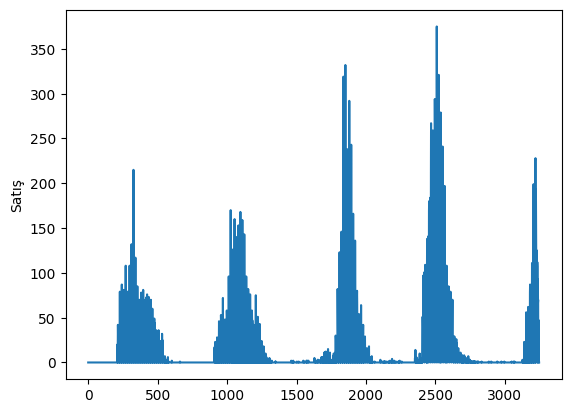

In [ ]:
sns.lineplot(x = data.index, y= data.Satış)

In [ ]:
data = data.drop(["Key"], axis = 1)

In [ ]:
# %80 train, %10 validation, %10 test
train_size = int(len(data['Satış'].values.reshape(-1,1)) * 0.8)
train_to_val_size = int(len(data['Satış'].values.reshape(-1,1)) * 0.9)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
# 4 hafta lag ile 1 hafta ilerisi tahmin edilecek
HORIZON = 1
WINDOW_SIZE = 4

In [ ]:
#laglı değerlerin oluşturulması
for i in range(WINDOW_SIZE):
  data[f"Satış+{i+1}"] = data["Satış"].shift(periods = i+1)

In [ ]:
X = data.dropna().drop(["Satış"], axis=1)
y = data.dropna()["Satış"]

In [ ]:
X_feature= X[["Yıl",	"Hafta", "Renk", "Keten"]]
X_lag= X.drop(["Marj","Yıl",	"Hafta", "Renk", "Keten"], axis = 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_feature = pd.get_dummies(X_feature)

In [ ]:
X_feat_train, X_feat_val, X_feat_test = X_feature[:train_size],X_feature[train_size:train_to_val_size], X_feature[train_to_val_size:]
y_train, y_val, y_test = y[:train_size],y[train_size:train_to_val_size],y[train_to_val_size:]

In [ ]:
X_ft_train_scaled = scaler.fit_transform(X_feat_train)
X_ft_val_scaled = scaler.transform(X_feat_val)
X_ft_test_scaled = scaler.transform(X_feat_test)

In [ ]:
scaler2 = MinMaxScaler()
X_lag_train, X_lag_val, X_lag_test = X_lag[:train_size],X_lag[train_size:train_to_val_size], X_lag[train_to_val_size:]

In [ ]:
X_lag_train_scaled = scaler2.fit_transform(X_lag_train)
X_lag_val_scaled = scaler2.transform(X_lag_val)
X_lag_test_scaled = scaler2.transform(X_lag_test)

In [ ]:
X_ft_train_scaled.shape, X_ft_val_scaled.shape, X_ft_test_scaled.shape, X_lag_train_scaled.shape, X_lag_val_scaled.shape, X_lag_test_scaled.shape

((2598, 17), (325, 17), (321, 17), (2598, 4), (325, 4), (321, 4))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((2598,), (325,), (321,))

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
WINDOW_SIZE = 4
HORIZON = 1
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(4, 5)

In [ ]:
# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS)

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE))

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast])

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast])
  forecast = layers.add([forecast, block_forecast])

feature_input = layers.Input(shape = X_ft_train_scaled.shape[1])

x = layers.Concatenate()([forecast, feature_input])
x = layers.Dense(128, activation = "relu")(x)
x = layers.Dropout((0.2))(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout((0.2))(x)
x = layers.Dense(32, activation = "relu")(x)
x = layers.Dropout((0.2))(x)
output = layers.Dense(1, activation = "linear")(x)

# 7. Put the stack model together
mv_model_nbeats_2 = tf.keras.Model(inputs=[stack_input, feature_input],
                                 outputs=output)


In [ ]:
keras.utils.plot_model(mv_model_nbeats_2)

In [ ]:
mv_model_nbeats_2.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mae")

In [ ]:
mv_model_nbeats_2.fit([X_lag_train_scaled, X_ft_train_scaled], y_train,
                    epochs=N_EPOCHS,
                    validation_data= ([X_lag_val_scaled, X_ft_val_scaled], y_val),
                    verbose= 1, # prevent large amounts of training outputs
                    # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [ ]:
mv_model_nbeats_2.evaluate([X_lag_train_scaled, X_ft_train_scaled], y_train)
mv_model_nbeats_2.evaluate([X_lag_val_scaled, X_ft_val_scaled], y_val)

11/11 [==============================] - 0s 9ms/step - loss: 1.5754


1.5754179954528809

In [ ]:
print(f"Sum of test set is: {np.sum(y_test)}")
print(f"Sum of predicted test set is: {np.sum(np.around(mv_model_nbeats_2.predict([X_lag_test_scaled, X_ft_test_scaled])).flatten())}")

Sum of test set is: 4364
11/11 [==============================] - 1s 13ms/step
Sum of predicted test set is: 3738.0


In [ ]:
X_test = X[["Marj", "Yıl",	"Hafta", "Renk", "Keten"]][train_to_val_size:]

In [ ]:
pd.DataFrame({"Yıl": X_test.Yıl,
              "Hafta": X_test.Hafta,
              "Renk": X_test.Renk,
              "Marj": X_test.Marj,
              "Keten": X_test.Keten,
              "pred": np.around(mv_model_nbeats_2.predict([X_lag_test_scaled, X_ft_test_scaled])).flatten(),
              "obs": y_test}).to_excel("multivarNBEATS-GM61.xlsx")

11/11 [==============================] - 0s 19ms/step
